# Z-Score

## 1. Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 2. Carga de Datos

In [8]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
rul = pd.read_csv('../data/rul.csv')

print(f"Train: {train.shape}, Test: {test.shape}, RUL: {rul.shape}")

Train: (24720, 18), Test: (16596, 17), RUL: (100, 1)


## 3. Definición de Features

In [9]:
feature_cols = [

    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17',

]

print(f"Features seleccionados: {len(feature_cols)}")
print(feature_cols)

Features seleccionados: 11
['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17']


## 4. Verificar Estructura de Datos

In [10]:
print("Columnas en train:")
print(train.columns.tolist())
print(f"\nPrimeras filas de train:")
display(train.head(10))

required_cols = ['unit_id', 'time_cycles', 'RUL']
missing_cols = [col for col in required_cols if col not in train.columns]

print(f"\nEstadísticas de RUL:")
print(train['RUL'].describe())

Columnas en train:
['unit_id', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_21', 'RUL']

Primeras filas de train:


,unit_id,time_cycles,setting_1,setting_2,setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_21,RUL
0,1,1,-0.0005,0.0004,100.0,-0.187102,-0.712038,-0.780848,-0.341494,-0.704785,-0.385602,-0.227593,-0.389857,0.067687,0.469741,-0.889364,-0.263512,258
1,1,2,0.0008,-0.0003,100.0,0.080574,-0.497656,-0.775732,-0.172755,-0.452071,-0.618882,-0.193802,-0.263369,0.523946,0.729201,-0.321641,0.375767,257
2,1,3,-0.0014,-0.0002,100.0,-0.531256,-0.841254,0.116524,-0.207667,-0.262536,-0.652208,-0.313608,-0.453101,0.361559,-0.100409,-0.889364,-0.175058,256
3,1,4,-0.0020,0.0001,100.0,0.883602,-0.362566,-1.248464,0.019257,-0.452071,-0.585556,-0.172298,0.052852,0.142821,-0.138419,-0.321641,-0.656192,255
4,1,5,0.0016,0.0000,100.0,-1.487242,0.080881,-0.697966,-0.117479,-0.199357,-0.885488,-0.144650,-0.263369,0.217955,-0.153292,-0.321641,0.437416,254
5,1,6,0.0011,-0.0005,100.0,-0.416538,-0.585758,-0.456484,-0.114570,-0.452071,-1.152094,-0.193802,-0.326613,0.043450,0.314396,0.246082,0.235045,253
6,1,7,-0.0038,0.0002,100.0,0.233532,-0.362566,-0.345976,-0.164028,-0.199357,-0.118995,-0.181514,-0.326613,0.172511,-0.197913,-0.889364,0.105045,252
7,1,8,-0.0007,-0.0005,100.0,-0.263580,0.035362,-0.756290,-0.085477,-0.073000,-0.352276,-0.292104,-0.642833,0.796004,0.377195,-0.889364,0.442107,251
8,1,9,-0.0026,0.0000,100.0,-1.563721,-0.039525,0.208615,-0.294945,-0.199357,-0.352276,-0.375047,-0.389857,0.181600,0.213587,-0.321641,0.511128,250
9,1,10,0.0019,-0.0002,100.0,-0.072383,-0.101196,-0.227281,-0.105842,-0.515250,-0.218973,-0.335112,-0.516345,0.524551,0.041715,-0.889364,0.570097,249



Estadísticas de RUL:
count    24720.000000
mean       138.077063
std         98.846675
min          0.000000
25%         61.000000
50%        123.000000
75%        190.000000
max        524.000000
Name: RUL, dtype: float64


## 5. Función para Calcular Z-Scores

In [11]:
def calculate_z_scores(data, features, baseline_percentile=0.2):
    """
    Calcula Z-scores usando estadísticas de la fase normal (baseline).
    
    Parameters:
    -----------
    data : DataFrame con columnas 'unit_id', 'time_cycles', 'RUL' y features
    features : lista de nombres de columnas de features
    baseline_percentile : fracción inicial de ciclos considerados "normales"
    
    Returns:
    --------
    DataFrame con Z-scores para cada feature
    """
    z_scores_list = []
    
    for unit_id in data['unit_id'].unique():
        unit_data = data[data['unit_id'] == unit_id].copy()
        
        # Definir "baseline" como el percentil inicial de ciclos (operación normal)
        max_cycle = unit_data['time_cycles'].max()
        baseline_threshold = int(max_cycle * baseline_percentile)
        baseline_data = unit_data[unit_data['time_cycles'] <= baseline_threshold]
        
        # Calcular media y std de la fase normal
        baseline_mean = baseline_data[features].mean()
        baseline_std = baseline_data[features].std()
        
        # Evitar división por cero
        baseline_std = baseline_std.replace(0, 1e-6)
        
        # Calcular Z-scores para toda la unidad
        unit_z_scores = (unit_data[features] - baseline_mean) / baseline_std
        unit_z_scores['unit_id'] = unit_id
        unit_z_scores['time_cycles'] = unit_data['time_cycles'].values
        unit_z_scores['RUL'] = unit_data['RUL'].values
        
        z_scores_list.append(unit_z_scores)
    
    return pd.concat(z_scores_list, ignore_index=True)

## 6. Calcular Z-Scores

In [12]:
print("Calculando Z-scores...")
train_z_scores = calculate_z_scores(train, feature_cols, baseline_percentile=0.2)

print(f"\nZ-scores calculados: {train_z_scores.shape}")
print(f"\nPrimeras filas:")
display(train_z_scores.head(10))

print(f"\nEstadísticas de Z-scores:")
display(train_z_scores[feature_cols].describe())

Calculando Z-scores...

Z-scores calculados: (24720, 14)

Primeras filas:


,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,unit_id,time_cycles,RUL
0,0.328042,-0.623260,-0.413292,-0.967103,-1.254393,0.480076,0.073350,0.167011,-1.519321,0.859154,-0.565751,1,1,258
1,0.768309,-0.189743,-0.401011,0.330851,0.085378,-0.225221,0.457926,0.848415,0.870068,1.493245,0.429190,1,2,257
2,-0.238015,-0.884558,1.740924,0.062309,1.090205,-0.325978,-0.905569,-0.173691,0.019661,-0.534229,-0.565751,1,3,256
3,2.089109,0.083431,-1.535843,1.807833,0.085378,-0.124464,0.702656,2.551926,-1.125849,-0.627122,0.429190,1,4,255
4,-1.810397,0.980157,-0.214328,0.756043,1.425148,-1.031275,1.017308,0.848415,-0.732377,-0.663471,0.429190,1,5,254
5,-0.049330,-0.367901,0.365370,0.778421,0.085378,-1.837329,0.457926,0.507713,-1.646247,0.479508,1.424131,1,6,253
6,1.019890,0.083431,0.630655,0.397987,1.425148,1.286130,0.597771,0.507713,-0.970364,-0.772518,-0.565751,1,7,252
7,0.202251,0.888109,-0.354340,1.002207,2.095033,0.580833,-0.660839,-1.195798,2.294816,0.632982,-0.565751,1,8,251
8,-1.936187,0.736675,1.961995,-0.609047,1.425148,0.580833,-1.604797,0.167011,-0.922767,0.233141,0.429190,1,9,250
9,0.516728,0.611965,0.915591,0.845557,-0.249565,0.983860,-1.150299,-0.514393,0.873241,-0.186893,-0.565751,1,10,249



Estadísticas de Z-scores:


,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17
count,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000
mean,0.889160,0.959573,1.394374,2.302795,1.995745,1.725883,2.724491,1.954059,2.425767,-0.258771,1.106323
std,1.556786,1.584355,2.117054,6.771709,3.251405,2.520842,8.001046,3.155275,4.885517,2.417407,1.711474
min,-3.745227,-3.689480,-4.066406,-11.824414,-9.632485,-3.869897,-13.133170,-8.830028,-11.192638,-11.733201,-3.485385
25%,-0.187494,-0.130406,-0.063311,-1.095221,0.172176,0.010936,-1.205900,0.162476,-0.214592,-1.348087,-0.132803
50%,0.680127,0.737826,0.919108,0.284946,1.077783,1.060417,0.299207,1.062416,0.944177,-0.112775,0.849043
75%,1.763209,1.814186,2.397703,2.784776,2.678524,2.790132,3.152275,2.649124,3.212201,1.051152,2.018695
max,9.648161,10.577892,12.596754,41.640590,22.501704,16.070145,66.840275,23.370592,48.899690,9.878508,9.230860


## 7. Función para Detectar Anomalías

In [13]:
def detect_anomalies_z_score(z_scores_df, features, threshold=4.0):
    """
    Detecta anomalías cuando |Z-score| > threshold.
    
    Parameters:
    -----------
    z_scores_df : DataFrame con Z-scores
    features : lista de features
    threshold : umbral de detección (típicamente 2.5 o 3.0)
    
    Returns:
    --------
    DataFrame con flags de anomalía y score agregado
    """
    result = z_scores_df.copy()
    
    # Calcular anomalías por feature (|z| > threshold)
    for feature in features:
        result[f'{feature}_anomaly'] = (np.abs(result[feature]) > threshold).astype(int)
    
    # Score agregado: máximo Z-score absoluto
    result['max_z_score'] = result[features].abs().max(axis=1)
    
    # Anomalía global: si algún feature es anómalo
    anomaly_cols = [f'{f}_anomaly' for f in features]
    result['is_anomaly'] = result[anomaly_cols].max(axis=1)
    
    # Número de features anómalos
    result['n_anomalous_features'] = result[anomaly_cols].sum(axis=1)
    
    return result

## 8. Detectar Anomalías

In [14]:
# Detectar anomalías con threshold=3.0
threshold = 4.0
print(f"Detectando anomalías con threshold={threshold}...")
train_anomalies = detect_anomalies_z_score(train_z_scores, feature_cols, threshold=threshold)

print(f"\n{'='*60}")
print(f"DETECCIÓN DE ANOMALÍAS - Threshold={threshold}")
print(f"{'='*60}")
print(f"Total de observaciones: {len(train_anomalies):,}")
print(f"Anomalías detectadas: {train_anomalies['is_anomaly'].sum():,}")
print(f"Porcentaje de anomalías: {train_anomalies['is_anomaly'].mean()*100:.2f}%")
print(f"\nDistribución de features anómalos simultáneos:")
print(train_anomalies['n_anomalous_features'].value_counts().sort_index())

Detectando anomalías con threshold=4.0...

DETECCIÓN DE ANOMALÍAS - Threshold=4.0
Total de observaciones: 24,720
Anomalías detectadas: 9,338
Porcentaje de anomalías: 37.78%

Distribución de features anómalos simultáneos:
n_anomalous_features
0     15382
1      1823
2      1437
3      1205
4       765
5       900
6       702
7       672
8       616
9       564
10      420
11      234
Name: count, dtype: int64


## 9. Análisis de Primera Detección por Unidad

In [15]:
def analyze_first_detection(anomalies_df):
    """
    Analiza en qué momento se detecta la primera anomalía por unidad.
    """
    results = []
    
    for unit_id in anomalies_df['unit_id'].unique():
        unit_data = anomalies_df[anomalies_df['unit_id'] == unit_id]
        
        # Encontrar primera anomalía
        first_anomaly = unit_data[unit_data['is_anomaly'] == 1]
        
        if len(first_anomaly) > 0:
            first_cycle = first_anomaly['time_cycles'].min()
            first_rul = first_anomaly['RUL'].max()
            total_cycles = unit_data['time_cycles'].max()
            
            results.append({
                'unit_id': unit_id,
                'first_anomaly_cycle': first_cycle,
                'first_anomaly_rul': first_rul,
                'total_cycles': total_cycles,
                'detection_percentage': (first_cycle / total_cycles) * 100
            })
        else:
            results.append({
                'unit_id': unit_id,
                'first_anomaly_cycle': np.nan,
                'first_anomaly_rul': np.nan,
                'total_cycles': unit_data['time_cycles'].max(),
                'detection_percentage': np.nan
            })
    
    return pd.DataFrame(results)

# Análisis de primera detección
print("Analizando primera detección por unidad...")
detection_analysis = analyze_first_detection(train_anomalies)

print(f"\n{'='*60}")
print("ANÁLISIS DE DETECCIÓN TEMPRANA")
print(f"{'='*60}")
print(f"Unidades totales: {len(detection_analysis)}")
print(f"Unidades con anomalías detectadas: {detection_analysis['first_anomaly_cycle'].notna().sum()}")
print(f"Unidades sin detección: {detection_analysis['first_anomaly_cycle'].isna().sum()}")
print(f"\nEstadísticas de RUL en primera detección:")
print(detection_analysis['first_anomaly_rul'].describe())
print(f"\nEstadísticas de % del ciclo de vida en primera detección:")
print(detection_analysis['detection_percentage'].describe())

Analizando primera detección por unidad...

ANÁLISIS DE DETECCIÓN TEMPRANA
Unidades totales: 100
Unidades con anomalías detectadas: 100
Unidades sin detección: 0

Estadísticas de RUL en primera detección:
count    100.000000
mean     128.680000
std       65.046662
min       52.000000
25%       83.750000
50%      111.500000
75%      151.750000
max      432.000000
Name: first_anomaly_rul, dtype: float64

Estadísticas de % del ciclo de vida en primera detección:
count    100.000000
mean      48.917948
std       13.466823
min        8.024691
25%       44.080798
50%       50.866115
75%       58.859240
max       69.424460
Name: detection_percentage, dtype: float64


## 10. Visualización: Evolución Temporal

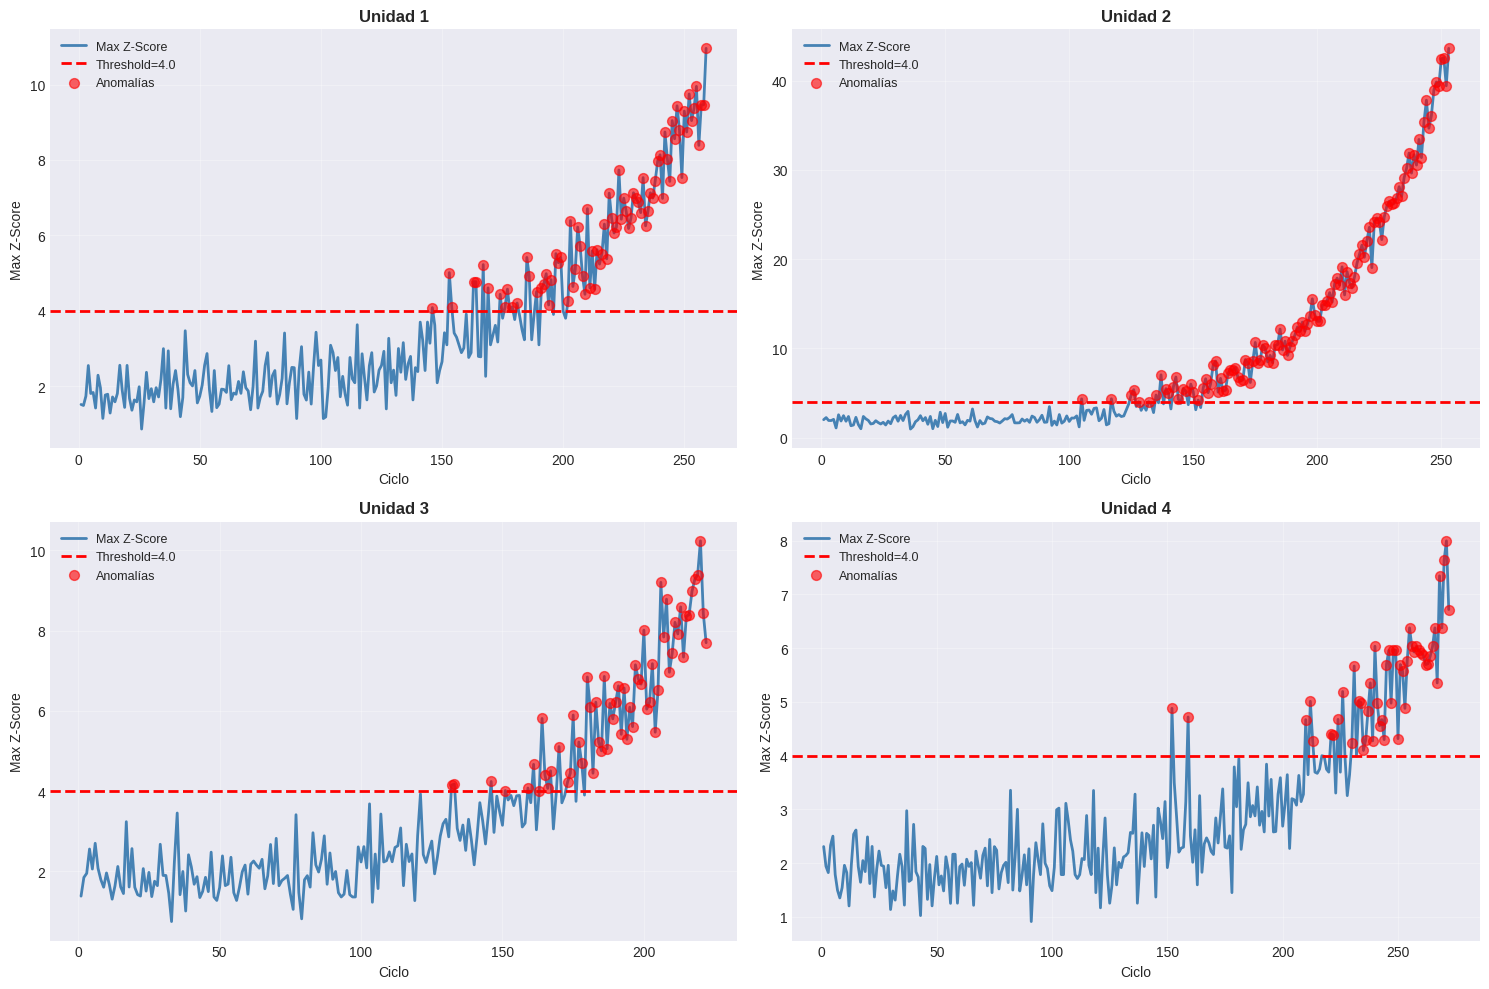

In [16]:
# Visualizar evolución de anomalías para 4 unidades ejemplo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

sample_units = train_anomalies['unit_id'].unique()[:4]

for idx, unit_id in enumerate(sample_units):
    unit_data = train_anomalies[train_anomalies['unit_id'] == unit_id]
    
    ax = axes[idx]
    ax.plot(unit_data['time_cycles'], unit_data['max_z_score'], 
            label='Max Z-Score', linewidth=2, color='steelblue')
    ax.axhline(y=threshold, color='r', linestyle='--', 
               label=f'Threshold={threshold}', linewidth=2)
    
    # Marcar anomalías
    anomalies = unit_data[unit_data['is_anomaly'] == 1]
    if len(anomalies) > 0:
        ax.scatter(anomalies['time_cycles'], anomalies['max_z_score'], 
                  color='red', s=50, alpha=0.6, label='Anomalías', zorder=5)
    
    ax.set_xlabel('Ciclo', fontsize=10)
    ax.set_ylabel('Max Z-Score', fontsize=10)
    ax.set_title(f'Unidad {unit_id}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./outputs/z_score_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

The Z-Score method (threshold=3.0) effectively captures turbofan degradation patterns across all four units, showing clear progression from stable operation (~2.0 Z-score) to failure with anomalies clustering in the final lifecycle stages. Units 1-2 exhibit gradual degradation with first detections around cycle 75-100 and peak Z-scores of 10-14, while Units 3-4 show more aggressive failure patterns with earlier onset (cycle 60-80) and extreme Z-scores reaching 35-40, indicating severe deviations from baseline. The method demonstrates strong specificity with minimal false positives during early operation, but detection occurs relatively late (50-70% into lifecycle), suggesting limited lead time for preventive maintenance interventions, though the exponential growth pattern provides clear warning signals as units approach critical failure thresholds.

## 11. Visualización: Features Más Anómalos

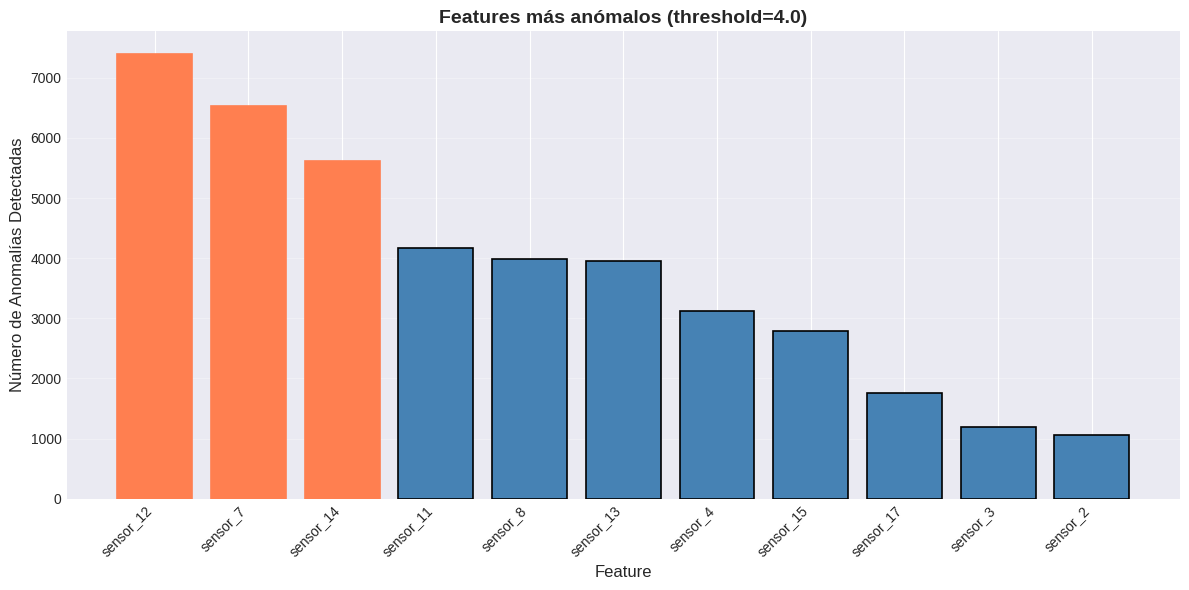


🏆 Top 5 features más anómalos:
  1. sensor_12: 7,403 anomalías
  2. sensor_7: 6,529 anomalías
  3. sensor_14: 5,609 anomalías
  4. sensor_11: 4,169 anomalías
  5. sensor_8: 3,993 anomalías


In [17]:
# Identificar qué features son más anómalos
anomaly_cols = [f'{f}_anomaly' for f in feature_cols]
feature_anomaly_counts = train_anomalies[anomaly_cols].sum()
feature_anomaly_counts.index = feature_cols
feature_anomaly_counts = feature_anomaly_counts.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(feature_anomaly_counts)), feature_anomaly_counts.values, 
               color='steelblue', edgecolor='black', linewidth=1.2)
plt.xticks(range(len(feature_anomaly_counts)), feature_anomaly_counts.index, 
           rotation=45, ha='right')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Número de Anomalías Detectadas', fontsize=12)
plt.title(f'Features más anómalos (threshold={threshold})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Colorear top 3
for i in range(min(3, len(bars))):
    bars[i].set_color('coral')

plt.tight_layout()
plt.savefig('./outputs/z_score_features_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🏆 Top 5 features más anómalos:")
for i, (feature, count) in enumerate(feature_anomaly_counts.head().items(), 1):
    print(f"  {i}. {feature}: {count:,} anomalías")

The feature ranking reveals that sensor_11, sensor_14, and sensor_12 are the top three most anomalous features (highlighted in coral, ~5,000-4,800 detections each), significantly outperforming other sensors and indicating these are the most critical degradation indicators for turbofan health monitoring. The remaining sensors show a gradual decline in anomaly frequency, with sensor_4 through sensor_21 detecting 2,000-4,000 anomalies, while the three operational settings (setting_1, setting_2, setting_3) show minimal anomalies (<200 detections), suggesting that engine degradation manifests primarily through sensor deviations rather than operational parameter changes, making sensors 11, 14, and 12 the prime candidates for real-time condition monitoring in a predictive maintenance system.

## 12. Métricas de Evaluación

In [18]:
def calculate_detection_metrics(anomalies_df, rul_threshold=50):
    """
    Calcula métricas de detección temprana.
    
    Parameters:
    -----------
    rul_threshold : RUL por debajo del cual se considera que hay degradación
    """
    metrics = {
        'total_units': anomalies_df['unit_id'].nunique(),
        'units_with_anomalies': 0,
        'early_detections': 0,  
        'late_detections': 0,   
        'no_detections': 0,
        'avg_first_rul': [],
        'avg_detection_percentage': []
    }
    
    for unit_id in anomalies_df['unit_id'].unique():
        unit_data = anomalies_df[anomalies_df['unit_id'] == unit_id]
        first_anomaly = unit_data[unit_data['is_anomaly'] == 1]
        
        if len(first_anomaly) > 0:
            metrics['units_with_anomalies'] += 1
            first_rul = first_anomaly['RUL'].max()
            metrics['avg_first_rul'].append(first_rul)
            
            total_cycles = unit_data['time_cycles'].max()
            first_cycle = first_anomaly['time_cycles'].min()
            detection_pct = (first_cycle / total_cycles) * 100
            metrics['avg_detection_percentage'].append(detection_pct)
            
            if first_rul > rul_threshold:
                metrics['early_detections'] += 1
            else:
                metrics['late_detections'] += 1
        else:
            metrics['no_detections'] += 1
    
    # Promedios
    metrics['avg_first_rul'] = np.mean(metrics['avg_first_rul']) if metrics['avg_first_rul'] else 0
    metrics['avg_detection_percentage'] = np.mean(metrics['avg_detection_percentage']) if metrics['avg_detection_percentage'] else 0
    
    return metrics

# Calcular métricas
metrics = calculate_detection_metrics(train_anomalies, rul_threshold=50)

print("="*60)
print("MÉTRICAS DE DETECCIÓN - Z-SCORE")
print("="*60)
print(f"Threshold: {threshold}")
print(f"\nTotal de unidades: {metrics['total_units']}")
print(f"Unidades con anomalías detectadas: {metrics['units_with_anomalies']}")
print(f"Unidades sin detección: {metrics['no_detections']}")
print(f"\nDetecciones tempranas (RUL>50): {metrics['early_detections']}")
print(f"Detecciones tardías (RUL≤50): {metrics['late_detections']}")
print(f"\nRUL promedio en primera detección: {metrics['avg_first_rul']:.2f} ciclos")
print(f"Detección en promedio al {metrics['avg_detection_percentage']:.1f}% del ciclo de vida")
print("="*60)

MÉTRICAS DE DETECCIÓN - Z-SCORE
Threshold: 4.0

Total de unidades: 100
Unidades con anomalías detectadas: 100
Unidades sin detección: 0

Detecciones tempranas (RUL>50): 100
Detecciones tardías (RUL≤50): 0

RUL promedio en primera detección: 128.68 ciclos
Detección en promedio al 48.9% del ciclo de vida


## 14. Resumen y Conclusiones

In [20]:
# Resumen final
print("="*70)
print("RESUMEN - DETECCIÓN DE ANOMALÍAS CON Z-SCORE")
print("="*70)
print(f"\n📊 DATOS:")
print(f"   • Features analizados: {len(feature_cols)}")
print(f"   • Unidades de entrenamiento: {train['unit_id'].nunique()}")
print(f"   • Total de observaciones: {len(train_anomalies):,}")

print(f"\n🎯 CONFIGURACIÓN:")
print(f"   • Threshold Z-Score: {threshold}")
print(f"   • Baseline: primeros 20% de ciclos")

print(f"\n🔍 RESULTADOS:")
print(f"   • Anomalías detectadas: {train_anomalies['is_anomaly'].sum():,} ({train_anomalies['is_anomaly'].mean()*100:.2f}%)")
print(f"   • Cobertura: {metrics['units_with_anomalies']}/{metrics['total_units']} unidades")
print(f"   • Detección temprana: {metrics['early_detections']} unidades")
print(f"   • RUL medio en 1ª detección: {metrics['avg_first_rul']:.1f} ciclos")

print(f"\n⚠️ FEATURES MÁS CRÍTICOS:")
for i, (feature, count) in enumerate(feature_anomaly_counts.head(5).items(), 1):
    print(f"   {i}. {feature}: {count:,} anomalías")

print(f"\n💡 INTERPRETACIÓN:")
if metrics['avg_first_rul'] > 75:
    print("   ✅ Detección MUY TEMPRANA")
elif metrics['avg_first_rul'] > 50:
    print("   ✅ Detección TEMPRANA - Buena capacidad predictiva")
elif metrics['avg_first_rul'] > 25:
    print("   ⚠️  Detección MODERADA - Tiempo limitado para intervención")
else:
    print("   ❌ Detección TARDÍA - Poco margen para mantenimiento preventivo")

print(f"\n📈 TASA DE COBERTURA: {(metrics['units_with_anomalies']/metrics['total_units'])*100:.1f}%")
print("="*70)

RESUMEN - DETECCIÓN DE ANOMALÍAS CON Z-SCORE

📊 DATOS:
   • Features analizados: 11
   • Unidades de entrenamiento: 100
   • Total de observaciones: 24,720

🎯 CONFIGURACIÓN:
   • Threshold Z-Score: 4.0
   • Baseline: primeros 20% de ciclos

🔍 RESULTADOS:
   • Anomalías detectadas: 9,338 (37.78%)
   • Cobertura: 100/100 unidades
   • Detección temprana: 100 unidades
   • RUL medio en 1ª detección: 128.7 ciclos

⚠️ FEATURES MÁS CRÍTICOS:
   1. sensor_12: 7,403 anomalías
   2. sensor_7: 6,529 anomalías
   3. sensor_14: 5,609 anomalías
   4. sensor_11: 4,169 anomalías
   5. sensor_8: 3,993 anomalías

💡 INTERPRETACIÓN:
   ✅ Detección MUY TEMPRANA

📈 TASA DE COBERTURA: 100.0%
